In [3]:
# Imports

import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import gnnx

from kgcnn.utils.adj import precompute_adjacency_scaled, scaled_adjacency_to_list
from kgcnn.literature.GCN import getmodelGCN
from kgcnn.utils.learning import lr_lin_reduction

## Loading the Graph Data

In [4]:
from dataloader import load_cora
cora_graph = load_cora('./data/csv/', categorial_class_labels=True)

def get_label_color(label):
    return plt.get_cmap('Set1')(label/7)
    
def get_label_name(label):
    return ["Case_Based",
		"Genetic_Algorithms",
		"Neural_Networks",
		"Probabilistic_Methods",
		"Reinforcement_Learning",
		"Rule_Learning",
		"Theory"][label]

## Preprocessing the Graph Data

In [5]:
adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(cora_graph)
edge_indices, edge_weights = scaled_adjacency_to_list(precompute_adjacency_scaled(adjacency_matrix))
node_features = np.array([cora_graph.nodes[n]['features'] for n in cora_graph.nodes])
node_labels = np.array([cora_graph.nodes[n]['label'] for n in cora_graph.nodes])

# GNN input [node_feature, edge_weights, edge_indices]
x = [tf.RaggedTensor.from_row_lengths(node_features, np.array([len(node_features)], dtype=np.int)),
             tf.RaggedTensor.from_row_lengths(np.expand_dims(edge_weights, axis=-1), np.array([len(edge_weights)], dtype=np.int)),
             tf.RaggedTensor.from_row_lengths(edge_indices, np.array([len(edge_indices)], dtype=np.int))]
# Ground truth labels
y = np.expand_dims(node_labels, axis=0)

In [6]:
train_ind, validation_ind = train_test_split(np.arange(node_labels.shape[0]), random_state=0)

train_mask = np.zeros(node_labels.shape[0])
train_mask[train_ind] = 1
train_mask = np.expand_dims(train_mask,axis=0)

validation_mask = np.zeros(node_labels.shape[0])
validation_mask[validation_ind] = 1
validation_mask = np.expand_dims(validation_mask, axis=0)

## Train the GNN Model

/pfs/work7/workspace/scratch/upnub-gnnx-0/conda/envs/gnnx2/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1/1 [==============================] - 0s 2ms/step - loss: 0.2191 - categorical_accuracy: 0.7637


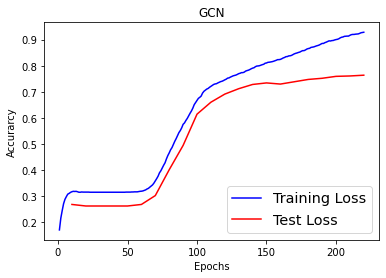

In [7]:
model = getmodelGCN(input_node_shape = [None,1432],
                    input_edge_shape = [None,1],
                    input_state_shape = [1],
                    input_type = 'ragged', 
                    # Output
                    output_use_bias = [True,True,False],
                    output_dim = [64,16,7],
                    output_activation = ['relu',
                                         'relu',
                                         'softmax'],
                    output_type = 'padded',
                    #model specs
                    depth = 3,
                    node_dim = 124,
                    hidden_dim = 124,
                    use_bias = True,
                    activation = 'relu',
                    graph_labeling = False,
                    has_unconnected=True)

learning_rate_start = 1e-4
epo = 220
epostep = 10
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              weighted_metrics = ['categorical_accuracy'])

trainlossall = []
testlossall = []
validlossall = []

for iepoch in range(0,epo,epostep):

    hist = model.fit(x, y, 
              epochs=iepoch+epostep,
              initial_epoch=iepoch,
              batch_size=1,
              verbose=0,
              sample_weight = train_mask)

    trainlossall.append(hist.history)
    testlossall.append(model.evaluate(x, y, sample_weight=validation_mask))    

testlossall = np.array(testlossall)
trainlossall = np.concatenate([x['categorical_accuracy'] for x in trainlossall])


#Plot loss vs epochs    
plt.figure()
plt.plot(np.arange(1,len(trainlossall)+1),trainlossall,label='Training Loss',c='blue')
plt.plot(np.arange(epostep,epo+epostep,epostep),testlossall[:,1],label='Test Loss',c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GCN')
plt.legend(loc='lower right',fontsize='x-large')
plt.show()

In [12]:
model.evaluate(x, y,sample_weight=validation_mask)

1/1 [==============================] - 0s 2ms/step - loss: 0.2191 - categorical_accuracy: 0.7637


[0.2191203385591507, 0.7636632323265076]

# Explaining Predictions

Implementing the GNNInterface:

In [13]:
class ExplainableGCN(gnnx.GNNInterface):
    
    def __init__(self, gnn_model, node_index, **kwargs):
        super(ExplainableGCN, self).__init__()
        self.gnn_model = gnn_model
        self.node_index = node_index
    
    def predict(self, gnn_input, masking_info=None):
        return tf.expand_dims(self.gnn_model(gnn_input, training=False)[0][self.node_index], 0)
        
    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input = gnn_input
        
        masked_edge_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(edge_input, tf.float32), edge_mask)
        masked_feature_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(node_input, tf.float32), tf.transpose(feature_mask))
        masked_pred = tf.expand_dims(self.gnn_model([masked_feature_input, masked_edge_input, edge_index_input], training=training)[0][self.node_index], 0)
        return masked_pred
    
    def get_number_of_nodes(self, gnn_input):
        node_input, _ , _ = gnn_input
        return node_input[0].shape[0]
    
    def get_number_of_node_features(self, gnn_input):
        node_input, _ , _ = gnn_input
        return node_input[0].shape[1]
    
    def get_number_of_edges(self, gnn_input):
        _ , edge_input, _ = gnn_input
        return edge_input[0].shape[0]
    
    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask, node_labels=None):
        edge_relevance = np.array(edge_mask[:,0])
        node_relevance = np.array(node_mask[:,0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        g = nx.Graph()
        for i, f in enumerate(features):
            if node_labels is None:
                g.add_node(i, features=f, relevance=node_relevance[i])
            else:
                g.add_node(i, features=f, relevance=node_relevance[i], label=node_labels[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                g.add_edge(e[0], e[1])
            else:
                g.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return g
    
    def present_explanation(self, explanation, threshold=0.5):
        relevant_edges = []
        edge_color_map = []
        for (v,u, relevance) in explanation.edges.data('relevance'):
            if relevance > threshold:
                relevant_edges.append((v,u))
                edge_color_map.append((0,0,0,relevance))
        subgraph = explanation.edge_subgraph(relevant_edges)
        node_colors = []
        for n,l in subgraph.nodes.data('label'):
            r,g,b,a = get_label_color(l)
            a = subgraph.nodes[n]['relevance']
            node_colors.append((r,g,b,a))
        nx.draw(subgraph, node_color=node_colors, edge_color=edge_color_map, with_labels=True)

In [14]:
# Helper functions

def get_output_tensor_for_label(label):
    assert label >= 0 and label <= 6
    output_to_explain = np.zeros(7)
    output_to_explain[label] = 1.
    output_to_explain = np.expand_dims(output_to_explain, 0)
    return tf.Variable(output_to_explain)

def get_label_from_tensor(tensor_output):
    return np.argmax(tensor_output)

Choose a node to explain and instantiate an explainable GNN:

In [40]:
node_index = np.argwhere(validation_mask[0] == 1)[:,0][0]
# node_index = 240
explainable_gcn = ExplainableGCN(model, node_index)

Get the prediction of the GNN for the chosen node:

In [41]:
prediction = explainable_gcn.predict(x)
predicted_label = get_label_from_tensor(prediction)
print('predicted label: ', predicted_label, get_label_name(predicted_label))
print('node_index: ', node_index)

predicted label:  6 Theory
node_index:  425


Setup the GNNExplainer:

In [42]:
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.001,
                 'edge_mask_norm_ord': 2,
                 'feature_mask_loss_weight': 0,
                 'feature_mask_norm_ord': 2,
                 'node_mask_loss_weight': 0,
                 'node_mask_norm_ord': 1}
compile_options = {'loss': 'categorical_crossentropy', 'optimizer': tf.keras.optimizers.Adam(lr=1)}
fit_options={'epochs': 80, 'verbose': 0}

explainer = gnnx.GNNExplainer(explainable_gcn,
                         compile_options=compile_options,
                         fit_options=fit_options,
                         gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/pfs/work7/workspace/scratch/upnub-gnnx-0/conda/envs/gnnx2/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Explain the instance with index `node_index`:

In [51]:
# inspection_result = explainer.explain(x, output_to_explain=get_output_tensor_for_label(1), inspection=True)
inspection_result = explainer.explain(x, inspection=True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/pfs/work7/workspace/scratch/upnub-gnnx-0/conda/envs/gnnx2/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Present the explanation

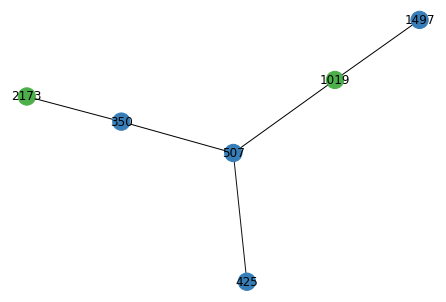

In [43]:
explainer.present_explanation(explainer.get_explanation(node_labels=np.argmax(y[0], axis=1)), threshold=0.1)

Plot the `inspection_result` to see if we chose suitable parameters:

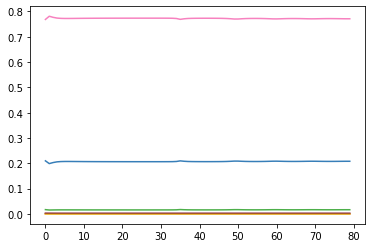

In [53]:
for i in range(7):
    plt.plot(np.array(inspection_result['predictions'])[:,i], color=get_label_color(i))

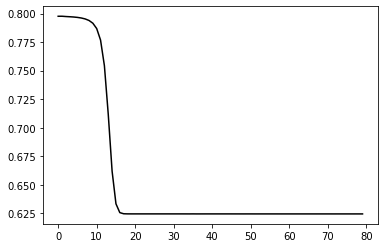

In [54]:
plt.plot(np.array(inspection_result['total_loss']), color="black")

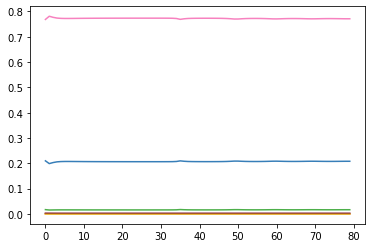

In [55]:
for i in range(7):
    plt.plot(np.array(inspection_result['predictions'])[:,i], color=get_label_color(i))

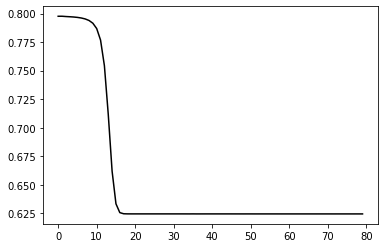

In [56]:
plt.plot(np.array(inspection_result['total_loss']), color="black")

For comparison, the 2-hop graph around the chosen instance:

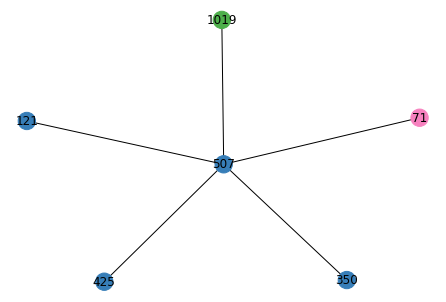

In [59]:
hops = 2
node_dict = {}
for i,n in enumerate(cora_graph.nodes):
    node_dict[n] = i
relabeled_cora = nx.relabel_nodes(cora_graph.to_undirected(), node_dict)
khopgraph = nx.generators.ego.ego_graph(relabeled_cora, node_index, radius=hops)
for n in khopgraph.nodes:
    khopgraph.nodes[n]['label'] = np.argmax(khopgraph.nodes[n]['label'])
    khopgraph.nodes[n]['relevance'] = 1.
for (u,v) in khopgraph.edges:
    khopgraph.edges[u,v]['relevance'] = 1.0
explainer.present_explanation(khopgraph)